<font size="8"> Dupire Local Volatility Pricer</font>

<font size="6"> Data exploration and visualization</font>

Importing the necessary libraries

In [56]:
import scipy.interpolate 
from scipy import integrate
import scipy.stats as ss
import time     
from scipy.stats import norm
import pandas as pd
import numpy as np
import datetime as dt
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sys import argv
from scipy.interpolate import griddata as gd
import math
from scipy.optimize import minimize
from keras.models import Sequential
from keras.layers import Dense

The dataset used contains all the information needed for the option chain, i.e maturity, strike, type of option, price, implied volatility. In our analysis we fix the starting date at 04/01/2017 and study volatility surface at that particular date

In [57]:
df = pd.read_csv('SPX_2016_options.csv')
df=df.iloc[:,np.r_[2:9,11:13,16]]
df.columns=['t','T','Maturity','Option','Strike Price','Bid price','Ask price','BS IV','Stock Price','interest rate']
df=df.dropna()

df = df[df['t']==min(df['t'])]

df['Maturity'] = df['Maturity']/365
df.insert(5,'Option Price',df[['Bid price','Ask price']].mean(axis=1))
df.drop(df[df['Option Price'] <= 0.05].index , inplace=True)

df = df[(df['Option'] == 1) & (df['Stock Price'].values < df['Strike Price']) | 
                                   (df['Option'] == -1) & (df['Stock Price'].values > df['Strike Price'])]
df['t']=df['t'].apply(dt.datetime.fromordinal).dt.strftime('%d-%m-%Y')
df['T']=df['T'].apply(dt.datetime.fromordinal).dt.strftime('%d-%m-%Y')
df['Moneyness'] = df['Strike Price']/df['Stock Price']
df['Total Var'] = df['BS IV']**2*df['Maturity']
df.reset_index(inplace=True)
df = df[df['BS IV'] < max(df['BS IV'])]
df

,index,t,T,Maturity,Option,Strike Price,Option Price,Bid price,Ask price,BS IV,Stock Price,interest rate,Moneyness,Total Var
0,155,04-01-2017,15-01-2017,0.030137,1,2015,24.45,23.40,25.50,0.195975,2012.66,0.007121,1.001163,0.001157
1,156,04-01-2017,15-01-2017,0.030137,1,2020,21.50,20.60,22.40,0.190988,2012.66,0.007121,1.003647,0.001099
2,157,04-01-2017,15-01-2017,0.030137,1,2025,19.05,18.10,20.00,0.188562,2012.66,0.007121,1.006131,0.001072
3,158,04-01-2017,15-01-2017,0.030137,1,2030,16.80,15.90,17.70,0.186419,2012.66,0.007121,1.008615,0.001047
4,159,04-01-2017,15-01-2017,0.030137,1,2035,14.70,13.80,15.60,0.184163,2012.66,0.007121,1.011100,0.001022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3401,7162,04-01-2017,31-12-2017,0.989041,-1,750,1.60,1.25,1.95,0.419134,2012.66,0.007121,0.372641,0.173748
3402,7163,04-01-2017,31-12-2017,0.989041,-1,800,2.15,1.80,2.50,0.408557,2012.66,0.007121,0.397484,0.165090
3403,7164,04-01-2017,31-12-2017,0.989041,-1,850,2.95,2.50,3.40,0.400543,2012.66,0.007121,0.422327,0.158677
3404,7165,04-01-2017,31-12-2017,0.989041,-1,900,3.85,3.30,4.40,0.390954,2012.66,0.007121,0.447169,0.151170


Plotting the IV surface given our datapoints

Text(0.5, 0, 'Implied Volatility')

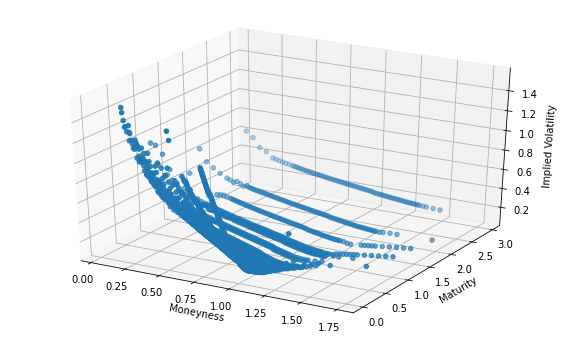

In [68]:
z = np.array(df['BS IV'])
x = np.array(df['Strike Price']/df['Stock Price'])
y = np.array(df['Maturity'])

fig1 = plt.figure(figsize=(10,6))
ax1=fig1.gca(projection='3d')
sc1=ax1.scatter(x, y, z)
#plt.colorbar(sc1)
ax1.set_xlabel('Moneyness')
ax1.set_ylabel('Maturity')
ax1.set_zlabel('Implied Volatility')

<font size="6"> Implied Volatility interpolation</font>

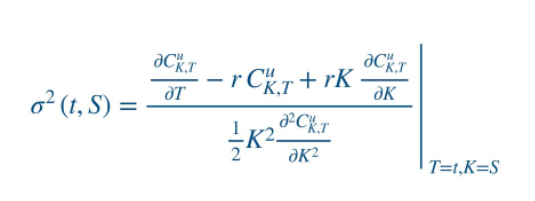


To compute local volatility we need many more data points than what we have in the dataset in order to compute more accurately the derivatives wrt to time and strike

<font size="4"> SVI</font>

Our first approach is to implementing the SVI (Stochastic Volatility Inspired) model, which is the baseline model used by practitioners in which we just need to tune 5 parameters (alpha, beta, rho, mu, sigma) to the market prices

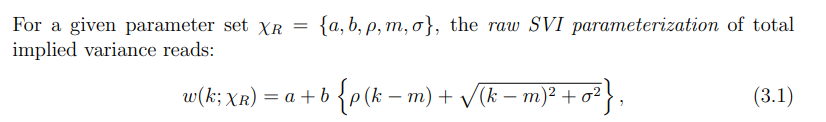


We define the formula and the optimization problem

In [59]:
def SVIPricer_vector(alpha, beta, rho, mm, sigma):
    parameter = alpha + beta*(rho*(strike - mm) + np.sqrt((strike - mm)**2 + sigma**2))
    return parameter

def SqErr(x):
    alpha, beta, rho, mm, sigma = x[0], x[1], x[2], x[3], x[4]
    err = np.sum((total_var - SVIPricer_vector(alpha, beta, rho, mm, sigma)) ** 2 / len(total_var))
    print(f"x={x}, err={err}")
    return err

Once we have found the fitted parameters we compute the Implied Volatility for a 100 x 100 (strike x maturity) grid as to have 10 000 observations

In [60]:
strike = np.log(df['Moneyness'])
total_var = df['Total Var']
x_start = [0, 0.1, 0, 0, 0.5]
bnds = ((-np.inf, np.inf),(0, np.inf),(-1, 1),(-np.inf, np.inf),(0, np.inf))
result = minimize(SqErr, x_start, method="L-BFGS-B", jac="3-point", bounds = bnds, tol=1.e-17)
x = result.x
alpha, beta, rho, mm, sigma = x[0], x[1], x[2], x[3], x[4]

nstep = 100
x_grid = np.linspace(min(df['Moneyness']), max(df['Moneyness']), nstep)
y_grid = np.linspace(min(df['Maturity']), max(df['Maturity']), nstep)

B1, B2 = np.meshgrid(x_grid, y_grid, indexing='xy')

Moneyness_arr = np. reshape(B1, B1.size)
Maturity_arr = np. reshape(B2, B2.size)

SVI = pd.DataFrame(data={'Moneyness': Moneyness_arr, 'Maturity': Maturity_arr})
SVI['Total Variance'] = alpha + beta*(rho*(np.log(SVI['Moneyness']) - mm) + np.sqrt((np.log(SVI['Moneyness']) - mm)**2 + sigma**2))
SVI['IV'] = np.sqrt(SVI['Total Variance']/SVI['Maturity'])

x=[0.  0.1 0.  0.  0.5], err=0.003441831317108678
x=[-6.05545445e-06  1.00000000e-01  0.00000000e+00  0.00000000e+00
  5.00000000e-01], err=0.003441551410043438
x=[6.05545445e-06 1.00000000e-01 0.00000000e+00 0.00000000e+00
 5.00000000e-01], err=0.0034421112975109745
x=[0.         0.09999394 0.         0.         0.5       ], err=0.0034417763364436964
x=[0.         0.10000606 0.         0.         0.5       ], err=0.003441886327928846
x=[ 0.00000000e+00  1.00000000e-01 -6.05545445e-06  0.00000000e+00
  5.00000000e-01], err=0.003441820353025084
x=[0.00000000e+00 1.00000000e-01 6.05545445e-06 0.00000000e+00
 5.00000000e-01], err=0.0034418422813104806
x=[ 0.00000000e+00  1.00000000e-01  0.00000000e+00 -6.05545445e-06
  5.00000000e-01], err=0.003441835890436401
x=[0.00000000e+00 1.00000000e-01 0.00000000e+00 6.05545445e-06
 5.00000000e-01], err=0.003441826744303646
x=[0.         0.1        0.         0.         0.49999394], err=0.0034417994374885664
x=[0.         0.1        0.         0.  

Clearly the fitted surface doesn't match the characteristics and values of the original datapoints. This is a very known limitation of SVI model for short maturities, and we ultimately need to discard this model

Text(0.5, 0, 'Implied Volatility')

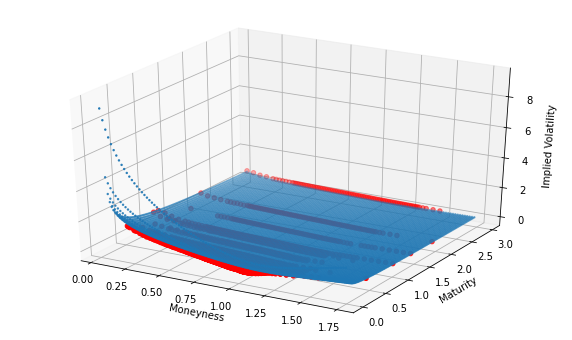

In [69]:
z_train = np.array(df['BS IV'])
x_train = np.array(df['Moneyness'])
y_train = np.array(df['Maturity'])

z = np.array(SVI['IV'])
x = np.array(SVI['Moneyness'])
y = np.array(SVI['Maturity'])

fig1 = plt.figure(figsize=(10,6))
ax1=fig1.gca(projection='3d')
sc2=ax1.scatter(x_train,y_train,z_train, c='r')
sc1=ax1.scatter(x, y, z, s = 2)
ax1.set_xlabel('Moneyness')
ax1.set_ylabel('Maturity')
ax1.set_zlabel('Implied Volatility')

<font size="4"> Neural Network Fitting</font>

The second approach is to use Machine Learning tools to fit interpolate the implied volatility surface, minimizing the MSE. The model is a standard feed-forward multi layer Neural Network

In [62]:
Y = df['BS IV']
X = df[['Moneyness','Maturity']]

model = Sequential()
model.add(Dense(8, input_dim=2, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mse', metrics=['mse']) 

nepoch = 15
nbatch = 16
model.fit(X, Y, epochs=nepoch, batch_size=nbatch)

Epoch 1/15
213/213 [==============================] - 1s 1ms/step - loss: 0.0365 - mse: 0.0365
Epoch 2/15
213/213 [==============================] - 0s 1ms/step - loss: 0.0071 - mse: 0.0071
Epoch 3/15
213/213 [==============================] - 0s 1ms/step - loss: 0.0037 - mse: 0.0037
Epoch 4/15
213/213 [==============================] - 0s 1ms/step - loss: 0.0027 - mse: 0.0027
Epoch 5/15
213/213 [==============================] - 0s 1ms/step - loss: 0.0023 - mse: 0.0023
Epoch 6/15
213/213 [==============================] - 0s 1ms/step - loss: 0.0017 - mse: 0.0017
Epoch 7/15
213/213 [==============================] - 0s 1ms/step - loss: 0.0016 - mse: 0.0016
Epoch 8/15
213/213 [==============================] - 0s 1ms/step - loss: 0.0014 - mse: 0.0014
Epoch 9/15
213/213 [==============================] - 0s 1ms/step - loss: 0.0014 - mse: 0.0014
Epoch 10/15
213/213 [==============================] - 0s 1ms/step - loss: 0.0013 - mse: 0.0013
Epoch 11/15
213/213 [============================

In [63]:
x_grid = np.linspace(min(df['Moneyness']), max(df['Moneyness']), nstep)
y_grid = np.linspace(min(df['Maturity']), max(df['Maturity']), nstep)

B1, B2 = np.meshgrid(x_grid, y_grid, indexing='xy')

Moneyness_arr = np. reshape(B1, B1.size)
Maturity_arr = np. reshape(B2, B2.size)

NN = pd.DataFrame(data={'Moneyness': Moneyness_arr, 'Maturity': Maturity_arr})
X_test = NN[['Moneyness','Maturity']]

Ylearn = model.predict(X_test)
NN['IV'] = Ylearn

The fit to the original datapoint in way better thean with SVI parametrization, but we can't gurarantee for arbitrage free characteristics, namely negative calendar spreads and negative butterflies.
Indeed originally the NN should have been run on top of the baseline model in order to correct for smoothness and arbitrage opportunities as in the paper "Deep Smoothing of the Implied Volatility Surface" Acherer et al., by including in the loss function soft constraints for negative derivative wrt to time and Durrelman condition

Text(0.5, 0, 'Implied Volatility')

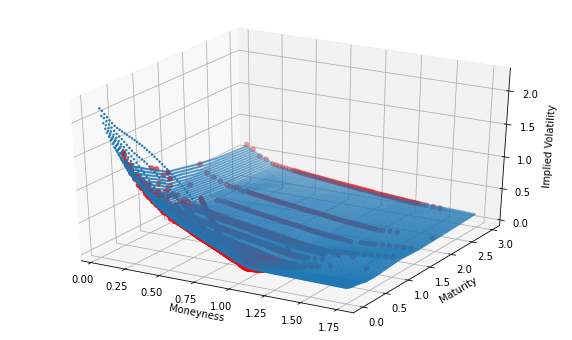

In [70]:
z_train = np.array(df['BS IV'])
x_train = np.array(df['Moneyness'])
y_train = np.array(df['Maturity'])

z = np.array(NN['IV'])
x = np.array(NN['Moneyness'])
y = np.array(NN['Maturity'])

fig1 = plt.figure(figsize=(10,6))
ax1=fig1.gca(projection='3d')
sc2=ax1.scatter(x_train,y_train,z_train, c='r')
sc1=ax1.scatter(x, y, z, s = 2)
ax1.set_xlabel('Moneyness')
ax1.set_ylabel('Maturity')
ax1.set_zlabel('Implied Volatility')

<font size="4"> Arbitrage free model</font>

To construct an arbitrage free surface we have to respect two conditions: absence of negative calendar spread and absence of negative butterflies

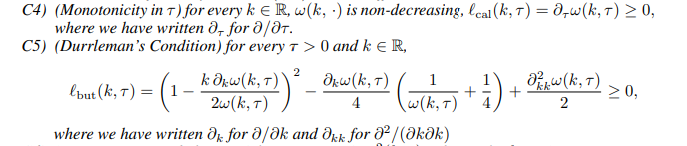

We define the functions to find the derivatives wrt time, k, k^2 and the Durrelman's condition

Further we specify the function to retrieve local volatility from the IV surface using an alternative but equivalent formulation

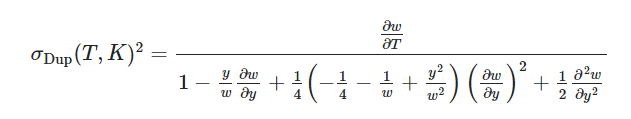


In [65]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]
    
def derivate_wrt_time(t0, y0, data):
    t0 = find_nearest(data['Maturity'],t0)
    y0 = find_nearest(data['Moneyness'],y0)
    t1 = t0 + dmaturity
    t1 = find_nearest(data['Maturity'],t1)
    
    C0 = data[(data['Moneyness']==y0) & (data['Maturity']==t0)]['Weighted_IV'].tolist()[0]
    C1 = data[(data['Moneyness']==y0) & (data['Maturity']==t1)]['Weighted_IV'].tolist()[0]
    
    derivative = (C1 - C0)/(t1 - t0)
    return derivative

def derivate_wrt_logmoneyness(t0, y0, data):
    r = 0.007
    t0 = find_nearest(data['Maturity'],t0)
    y0 = find_nearest(data['Moneyness'],y0)
    y1 = y0 + dmoneyness
    y1 = find_nearest(data['Moneyness'],y1)
    
    C0 = data[(data['Moneyness']==y0) & (data['Maturity']==t0)]['Weighted_IV'].tolist()[0]
    C1 = data[(data['Moneyness']==y1) & (data['Maturity']==t0)]['Weighted_IV'].tolist()[0]
    
    derivative = (C1 - C0)/(np.log(y1/np.exp(t0*r)) - np.log(y0/np.exp(t0*r)))
    return derivative

def second_derivate_wrt_logmoneyness(t0, y0, data):
    r = 0.007
    t0 = find_nearest(data['Maturity'],t0)
    y0 = find_nearest(data['Moneyness'],y0)
    y1 = y0 + dmoneyness
    y1 = find_nearest(data['Moneyness'],y1)
    
    y2 = y0 - dmoneyness
    y2 = find_nearest(data['Moneyness'],y2)
    
    C0 = data[(data['Moneyness']==y0) & (data['Maturity']==t0)]['Weighted_IV'].tolist()[0]
    C1 = data[(data['Moneyness']==y1) & (data['Maturity']==t0)]['Weighted_IV'].tolist()[0]
    C2 = data[(data['Moneyness']==y2) & (data['Maturity']==t0)]['Weighted_IV'].tolist()[0]
    
    
    derivative = ((C1 - C0)/(np.log(y1/np.exp(t0*r)) - np.log(y0/np.exp(t0*r))) - (C0 - C2)/(np.log(y0/np.exp(t0*r)) - np.log(y2/np.exp(t0*r))))*(2/(np.log(y1/np.exp(t0*r)) - np.log(y2/np.exp(t0*r))))
          
    return derivative

def local_vol(t0, y0, data):
    dt = derivate_wrt_time(t0, y0, data)
    dK = derivate_wrt_logmoneyness(t0, y0, data)
    dKK = second_derivate_wrt_logmoneyness(t0, y0, data)
    
    
    t0 = find_nearest(data['Maturity'],t0)
    y0 = find_nearest(data['Moneyness'],y0)
    
    w = data[(data['Moneyness']==y0) & (data['Maturity']==t0)]['Weighted_IV'].tolist()[0]
   
    ss = dt/(1 - (np.log(y0)/np.exp(t0))/w*dK + 0.5*dKK + 0.25*((np.log(y0)/np.exp(t0))**2/w**2 - 1/w - 0.25)*dK**2)
    
    return np.sqrt(ss)

def Durrelman_condition(w0, y0, dk, dkk):
    butt_arb = (((1 - y0*dk)/(2*w0))**2 - dk/4*(1/w0 + 0.25) + dkk/2)
    return butt_arb

Trough the scipy library we run different types of interpolations (7) with different paramter of smoothness (7) and we select the best model as the one with the closest range to observations among the arbitrage free models (13/49).
The best model is the cubic interpolation with smoothness = -3 and we can be sure it is arbitrage free

In [66]:
functions = ['cubic', 'gaussian', 'inverse_multiquadric', 'linear', 'multiquadric', 'quintic', 'thin_plate']
total_exc = np.inf
best_range = np.inf
range_IV = max(df['BS IV']) - min(df['BS IV'])

for j in range (-3,4,1):
    
    for i in functions:
        
        z = np.array(df['BS IV'])
        x = np.array(df['Moneyness'])
        y = np.array(df['Maturity']/365)

        nstep = 20
        
        x_grid = np.linspace(min(x), max(x), nstep)
        y_grid = np.linspace(min(y), max(y), nstep)

        dmoneyness = (max(x) - min(x))/nstep
        dmaturity = (max(y) - min(y))/nstep

        B1, B2 = np.meshgrid(x_grid, y_grid, indexing='xy')
        Z = np.zeros((x.size, z.size))
        spline = scipy.interpolate.Rbf(x,y,z,function=i,smooth=j)
        Z = spline(B1,B2)
        
        IV_arr = np. reshape(Z, Z.size)
        Moneyness_arr = np. reshape(B1, B1.size)
        Maturity_arr = np. reshape(B2, B2.size)
        Weighted_vol_arr = IV_arr**2*Maturity_arr

        local = pd.DataFrame(data={'Moneyness': Moneyness_arr, 'Maturity': Maturity_arr, 'IV' : IV_arr, 'Weighted_IV' : Weighted_vol_arr})
        
        countdt = 0
        countdk = 0
        
        for z in range(0,len(local)):
            t0 = local.iloc[[z]]['Maturity'][z]
            y0 = local.iloc[[z]]['Moneyness'][z]
            w0 = local.iloc[[z]]['Weighted_IV'][z]
            
            if derivate_wrt_time(t0, y0, local) < 0:
                countdt += 1
            
            dk = derivate_wrt_logmoneyness(t0, y0, local)
            dkk= second_derivate_wrt_logmoneyness(t0, y0, local)
            
            if Durrelman_condition(w0, y0, dk, dkk) < 0:
                countdk += 1
                
        
        if countdt + countdk  == 0 and min(IV_arr) > 0:
            range_model = max(local['IV']) - min(local['IV'])
            if abs(range_model - range_IV) < best_range:
                best_range = range_model - range_IV
                best_model = 'function = ' + str(i) + ' smoothness = ' + str(j)
                
print(best_model)

<ipython-input-65-3088f8f4bef6>:46: RuntimeWarning: invalid value encountered in double_scalars
  derivative = ((C1 - C0)/(np.log(y1/np.exp(t0*r)) - np.log(y0/np.exp(t0*r))) - (C0 - C2)/(np.log(y0/np.exp(t0*r)) - np.log(y2/np.exp(t0*r))))*(2/(np.log(y1/np.exp(t0*r)) - np.log(y2/np.exp(t0*r))))
<ipython-input-65-3088f8f4bef6>:28: RuntimeWarning: invalid value encountered in double_scalars
  derivative = (C1 - C0)/(np.log(y1/np.exp(t0*r)) - np.log(y0/np.exp(t0*r)))
<ipython-input-65-3088f8f4bef6>:15: RuntimeWarning: invalid value encountered in double_scalars
  derivative = (C1 - C0)/(t1 - t0)
C:\Users\aleta\anaconda3\lib\site-packages\scipy\interpolate\rbf.py:257: LinAlgWarning: Ill-conditioned matrix (rcond=6.64688e-19): result may not be accurate.
  self.nodes = linalg.solve(self.A, self.di)
C:\Users\aleta\anaconda3\lib\site-packages\scipy\interpolate\rbf.py:257: LinAlgWarning: Ill-conditioned matrix (rcond=4.56368e-22): result may not be accurate.
  self.nodes = linalg.solve(self.A, 

function = cubic smoothness = -3


The model fits well the datapoints

Text(0.5, 0, 'Implied Volatility')

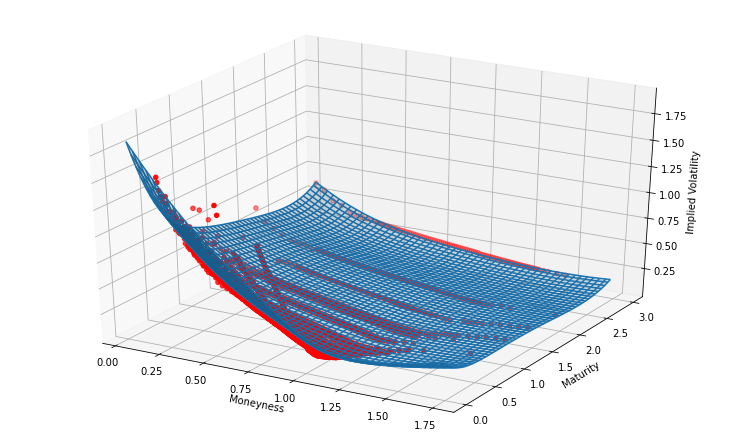

In [72]:
z = np.array(df['BS IV'])
x = np.array(df['Moneyness'])
y = np.array(df['Maturity'])

nstep = 200

x_grid = np.linspace(min(x), max(x), nstep)
y_grid = np.linspace(min(y), max(y), nstep)

dmoneyness = (max(x) - min(x))/nstep
dmaturity = (max(y) - min(y))/nstep

B1, B2 = np.meshgrid(x_grid, y_grid, indexing='xy')
Z = np.zeros((x.size, z.size))

spline = scipy.interpolate.Rbf(x,y,z,function='cubic',smooth=-3)

Z = spline(B1,B2)
fig = plt.figure(figsize=(10,6))
ax = Axes3D(fig)
ax.plot_wireframe(B1, B2, Z)
ax.plot_surface(B1, B2, Z,alpha=0.2)
ax.scatter3D(x,y,z, c='r')
ax.set_xlabel('Moneyness')
ax.set_ylabel('Maturity')
ax.set_zlabel('Implied Volatility')

<font size="6"> Price Dynamics</font>

We contruict the dataset with the interpolated surface

In [73]:
IV_arr = np. reshape(Z, Z.size)
Moneyness_arr = np. reshape(B1, B1.size)
Maturity_arr = np. reshape(B2, B2.size)
Weighted_vol_arr = IV_arr**2*Maturity_arr

local = pd.DataFrame(data={'Moneyness': Moneyness_arr, 'Maturity': Maturity_arr, 'IV' : IV_arr, 'Weighted_IV' : Weighted_vol_arr})
print(local.tail(10))

print(min(local['IV']))

       Moneyness  Maturity        IV  Weighted_IV
39990   1.662591  2.964384  0.159854     0.075750
39991   1.671080  2.964384  0.160719     0.076572
39992   1.679569  2.964384  0.161622     0.077434
39993   1.688058  2.964384  0.162563     0.078339
39994   1.696547  2.964384  0.163542     0.079285
39995   1.705036  2.964384  0.164559     0.080274
39996   1.713525  2.964384  0.165615     0.081308
39997   1.722014  2.964384  0.166710     0.082387
39998   1.730503  2.964384  0.167844     0.083512
39999   1.738992  2.964384  0.169018     0.084684
0.0943493172952981


Defining the path generating function trough discretiazation for each time-step, changing the volatility accordingly

In [74]:
def gen_local_paths(S0, K, r, T, M, I):
    
    dt = float(T) / M
    paths = np.zeros((M-1, I), np.float64)
    paths[0]=S0
    
    for i in range (0, I):
        S = S0
        for j in range(1, M-1 ):
            
            rand = np.random.standard_normal()
            y = K/S
            ttm = T - dt*j
            sigma = local_vol(ttm,y, local)
            paths[j][i] = paths[j-1][i] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * rand)
            
    return(paths)

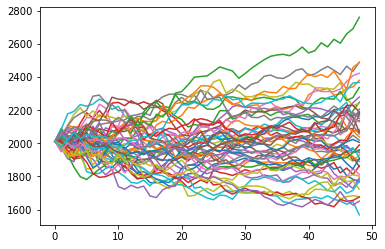

In [75]:
plt.plot(gen_local_paths(2012.66, 2000 , 0.007, 0.5, 50, 50))

Defining the pricing functions

In [76]:
def call_payout(x, K, r, T):
        return max(x - K, 0)*np.exp(-r*T)

def put_payout(x, K, r, T):
        return max(K - x, 0)*np.exp(-r*T)

def BS_CALL(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r*T)* norm.cdf(d2)

def BS_PUT(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma* np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

def local_call_price(S0, K, r, T, M, I):
    payouts = gen_local_paths(S0, K, r, T, M, I)[-1]
    payoffs = [call_payout(x, K, r, T) for x in payouts]
    price = sum(payoffs)/I
    return(price)

def local_put_price(S0, K, r, T, M, I):
    payouts = gen_local_paths(S0, K, r, T, M, I)[-1]
    payoffs = [call_payout(x, K, r, T) for x in payouts]
    price = sum(payoffs)/I
    return(price)

def local_barrier_UI_Call_price(S0, K, r, T, M, I, B):
    paths = gen_local_paths(S0, K, r, T, M, I)
    price = 0
    
    for i in range(0,I):
        if all(x < B for x in paths[:,i])==True:
            price += 0
        else:
            payoffs = call_payout(paths[:,i][-1], K, r, T)
            price += payoffs   
    return(price/I)

def local_barrier_UO_Call_price(S0, K, r, T, M, I, B):
    paths = gen_local_paths(S0, K, r, T, M, I)
    price = 0
    
    for i in range(0,I):
        if all(x < B for x in paths[:,i])==True:
            payoffs = call_payout(paths[:,i][-1], K, r, T)
            price += payoffs   
        else:
            price += 0
    return(price/I)

def local_barrier_DI_Call_price(S0, K, r, T, M, I, B):
    paths = gen_local_paths(S0, K, r, T, M, I)
    price = 0
    
    for i in range(0,I):
        if all(x > B for x in paths[:,i])==True:
            price += 0
        else:
            payoffs = call_payout(paths[:,i][-1], K, r, T)
            price += payoffs   
    return(price/I)

def local_barrier_DO_Call_price(S0, K, r, T, M, I, B):
    paths = gen_local_paths(S0, K, r, T, M, I)
    price = 0
    
    for i in range(0,I):
        if all(x > B for x in paths[:,i])==True:
            payoffs = call_payout(paths[:,i][-1], K, r, T)
            price += payoffs   
        else:
            price += 0
    return(price/I)

def local_barrier_UI_Put_price(S0, K, r, T, M, I, B):
    paths = gen_local_paths(S0, K, r, T, M, I)
    price = 0
    
    for i in range(0,I):
        if all(x < B for x in paths[:,i])==True:
            price += 0
        else:
            payoffs = put_payout(paths[:,i][-1], K, r, T)
            price += payoffs   
    return(price/I)

def local_barrier_UO_Put_price(S0, K, r, T, M, I, B):
    paths = gen_local_paths(S0, K, r, T, M, I)
    price = 0
    
    for i in range(0,I):
        if all(x < B for x in paths[:,i])==True:
            payoffs = put_payout(paths[:,i][-1], K, r, T)
            price += payoffs   
        else:
            price += 0
    return(price/I)

def local_barrier_DI_Put_price(S0, K, r, T, M, I, B):
    paths = gen_local_paths(S0, K, r, T, M, I)
    price = 0
    
    for i in range(0,I):
        if all(x > B for x in paths[:,i])==True:
            price += 0
        else:
            payoffs = put_payout(paths[:,i][-1], K, r, T)
            price += payoffs   
    return(price/I)

def local_barrier_DO_Put_price(S0, K, r, T, M, I, B):
    paths = gen_local_paths(S0, K, r, T, M, I)
    price = 0
    
    for i in range(0,I):
        if all(x > B for x in paths[:,i])==True:
            payoffs = put_payout(paths[:,i][-1], K, r, T)
            price += payoffs   
        else:
            price += 0
    return(price/I)

In [147]:
local_call_price(2012.66, 2012.66, 0.007, 0.5, 10, 100)

80.85753337048317

In [148]:
local_barrier_UI_price(2012.66, 2012.66, 0.007, 0.5, 10, 100,2100)

66.45167000772015

In [149]:
local_barrier_UO_price(2012.66, 2012.66, 0.007, 0.5, 10, 100,2100)

1.2677643730765822

In [152]:
local_barrier_DI_price(2012.66, 2012.66, 0.007, 0.5, 10, 100,1900)

0.4449931926649957

In [155]:
local_barrier_DO_price(2012.66, 2012.66, 0.007, 0.5, 10, 100,1800)

78.2775776147827

In [158]:
local_put_price(2012.66, 2012.66, 0.007, 0.5, 10, 100)

75.84599823412505

In [157]:
local_barrier_DI_Put_price(2012.66, 2012.66, 0.007, 0.5, 10, 100,1900)

72.48248789257717

In [159]:
local_barrier_DO_Put_price(2012.66, 2012.66, 0.007, 0.5, 10, 100,1900)

4.2828215968079935

In [162]:
local_barrier_UI_Put_price(2012.66, 2012.66, 0.007, 0.5, 10, 100,2100)

5.5215919725093485

In [163]:
local_barrier_UO_Put_price(2012.66, 2012.66, 0.007, 0.5, 10, 100,2100)

67.2716422767651